<a href="https://colab.research.google.com/github/stepanl-bsy/langgraph_tutorial/blob/main/1_lang_building_react_agent_from_scratch_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Required libraries

In [1]:

%pip install -q langgraph  langchain langchain_community langchain_google_genai
# google-cloud-aiplatform vertexai langgraph langchain_google_vertexai


requirements:

1. Google ai studio (gemini) api key
https://aistudio.google.com/apikey

2. tavily search engine api key:
   https://tavily.com/

## Complexity of approaches in llm applications

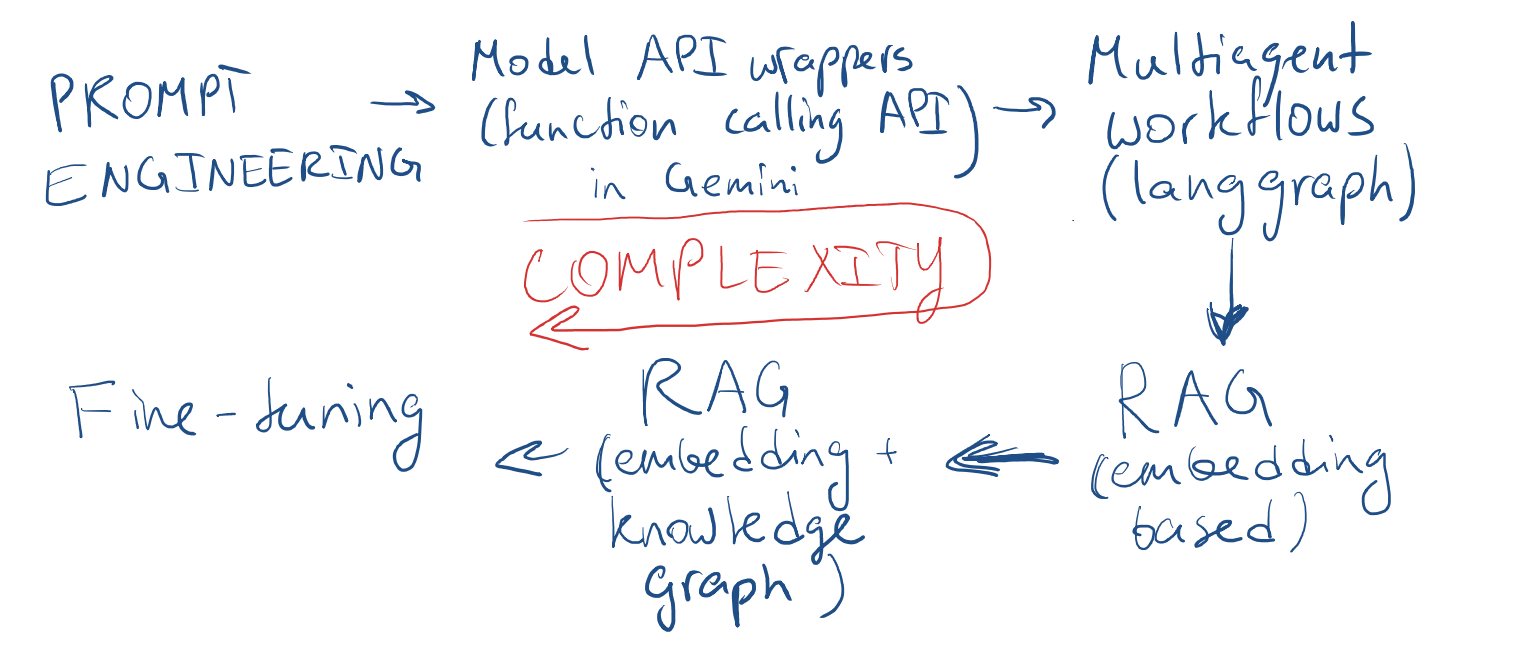

## Agents and tools
Modified from:
from deeplearning.ai:
https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/
https://github.com/grbcool/AI-Agents-in-the-LangGraph/

### Agent
A personality - researcher, editor, etc. We define it as a **system prompt** for our llm. System prompts defines how the llm should behave like.
Note, in Vertex AI, system prompts are apart of user prompt, in Open AI, they are separate.

## Tools
Tools at it's disposal - rag retrievers, search tools (google scholar, arxiv, etc), calculators, you name it. You can even have tools that execute [python code to create charts etc](https://python.langchain.com/docs/integrations/tools/python/), but these can screw up your environment. You can have tools that execute sql or cypher (sql-like language for knowledge graphs) and even check that the resultant query is valid.


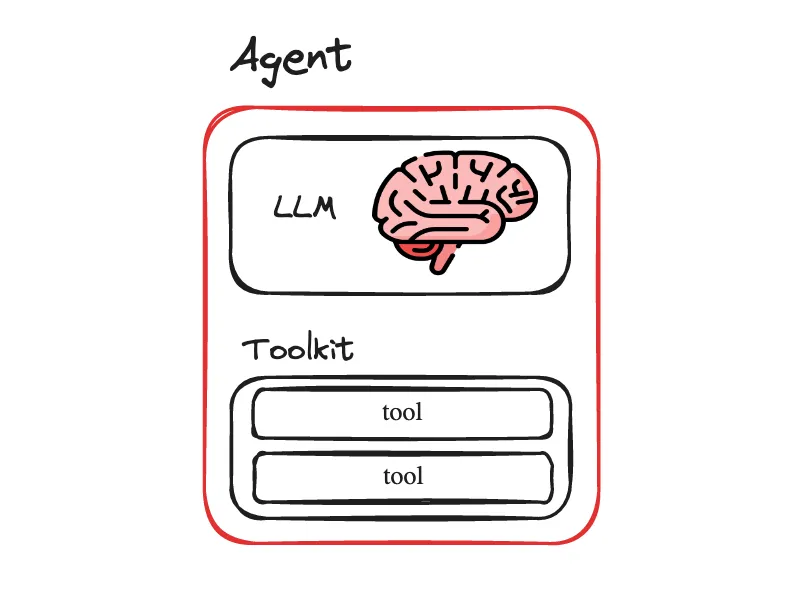

## Why agents are important?
 - Satya Nadella (Microsoft CEO) just spent a [couple hours in London talking about agents](https://www.youtube.com/watch?v=kOkDTvsUuWA) and how Microsoft is building an agent library on top of Azure OpenAI
 - OpenAI has build it's own Agent framework [Swarm](https://github.com/openai/swarm)
 - Google is following [with Docs Agent](https://ai.google.dev/gemini-api/tutorials/docs-agent)

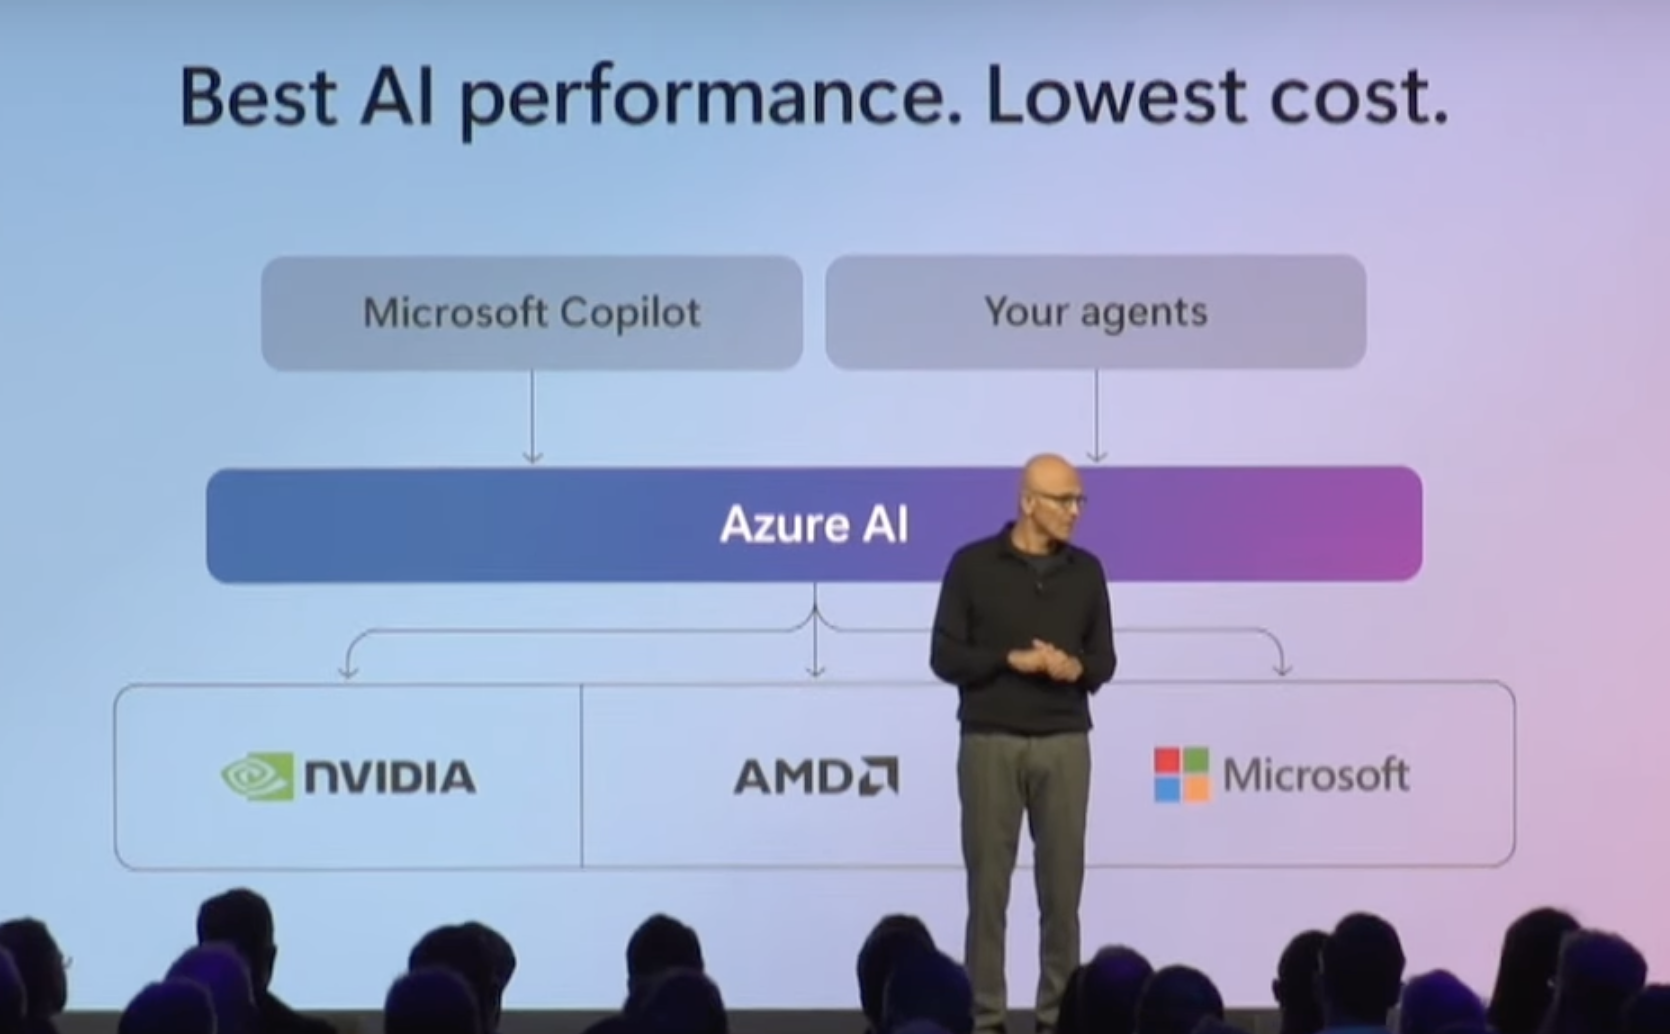

## Agents can make gpt3.5 outperform gpt4
https://youtu.be/sal78ACtGTc?si=c_LsO3Kddh5WQZqn

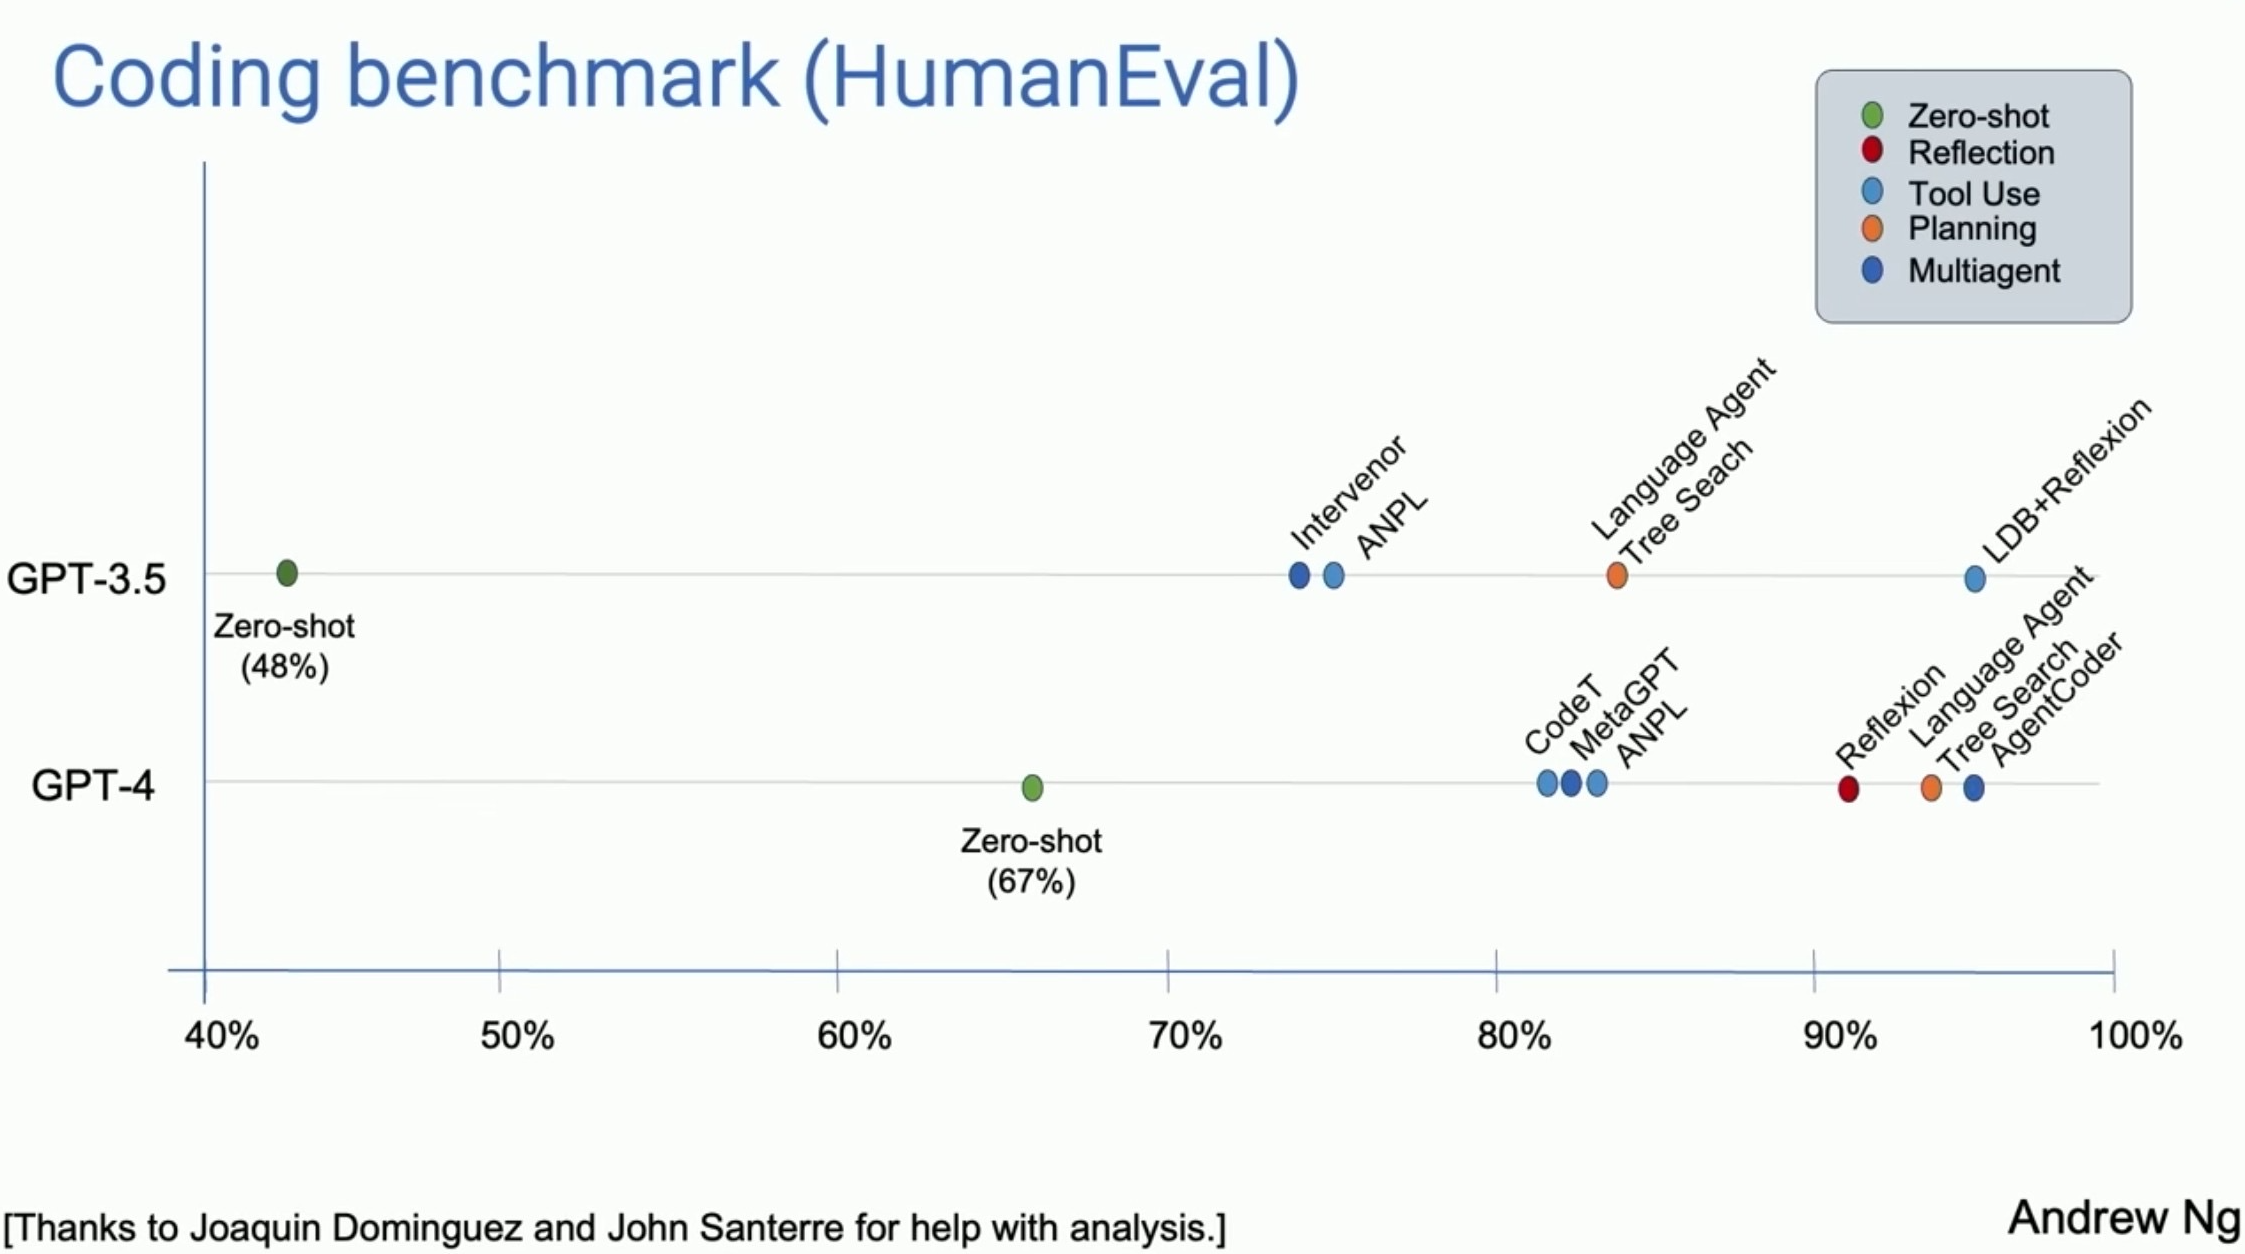

## Apple research findings
 - LLMs don't really reason. They extrapolate reasoning examples they've seen in training data onto what the user asks them
 - "Red herrings" can confuse them. In the example with the smaller kiwis, for instance, most models try to subtract the smaller fruits from the final total because, the researchers surmise, "their training datasets included similar examples that required conversion to subtraction operations." This is the kind of "critical flaw" that the researchers say "suggests deeper issues in [the models'] reasoning processes" that can't be helped with fine-tuning or other refinements.

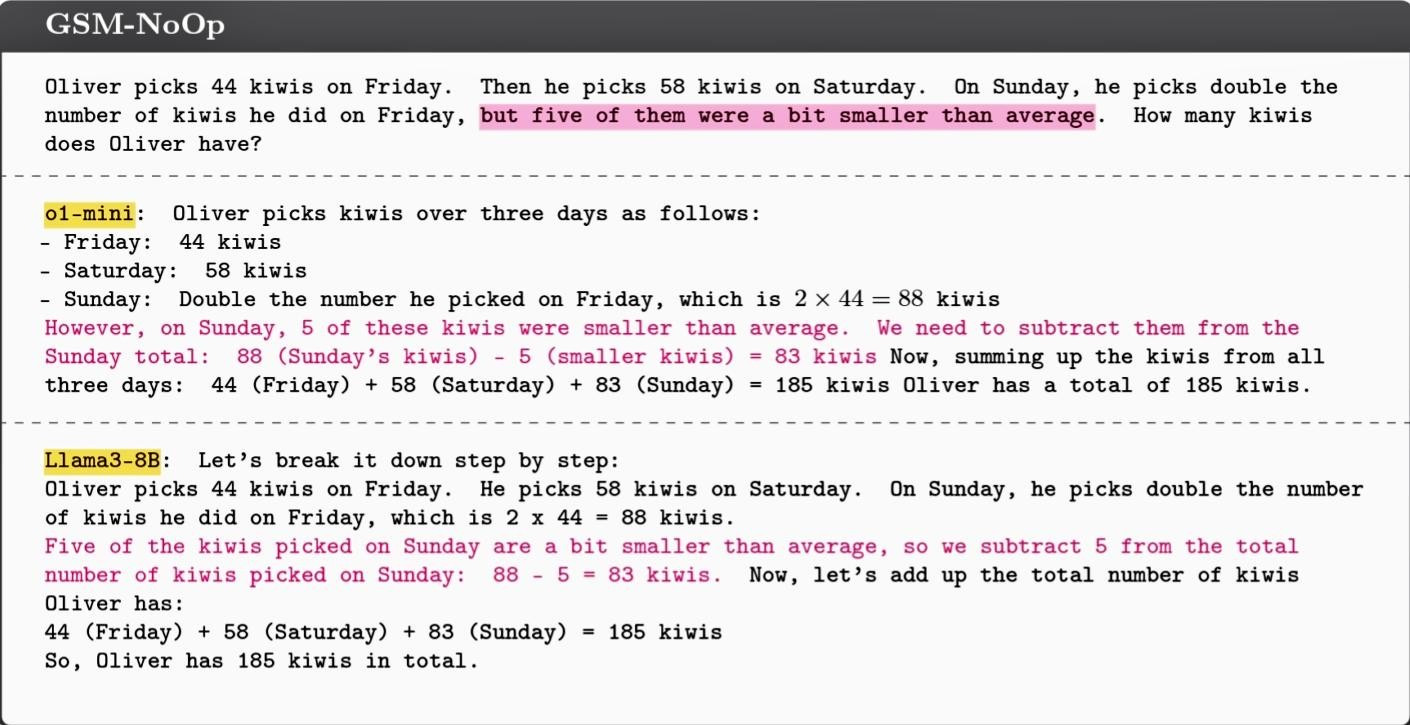

### Drop in performance across models (% accuracy) due to addition of red herrings

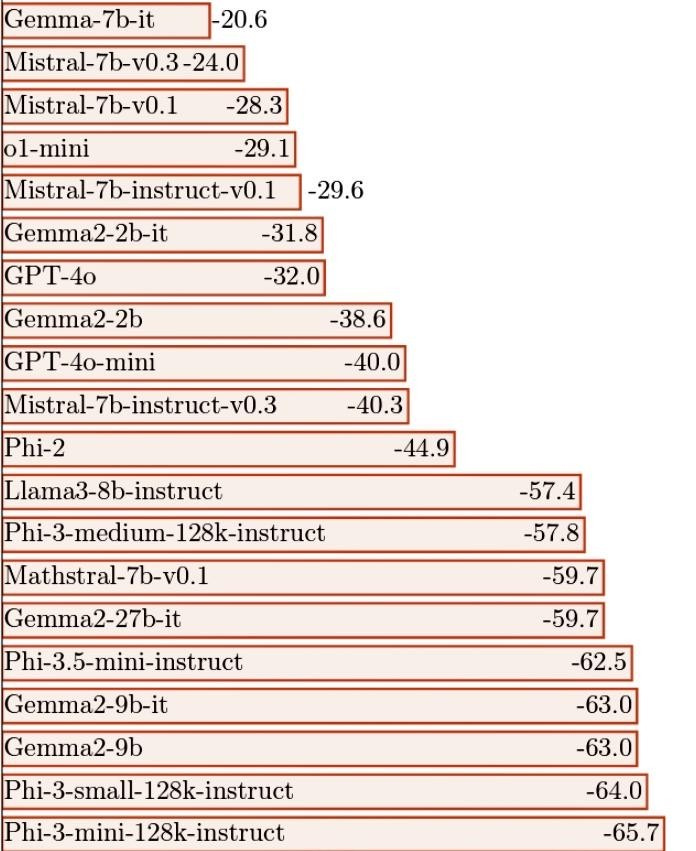

## Agents are a possible solution
 - They force the model to reason by breaking down user prompts into reasoning chains
 - Or by modyfying the user prompt into a plan and executing the tasks one-by-one

## Building a react agent from scratch

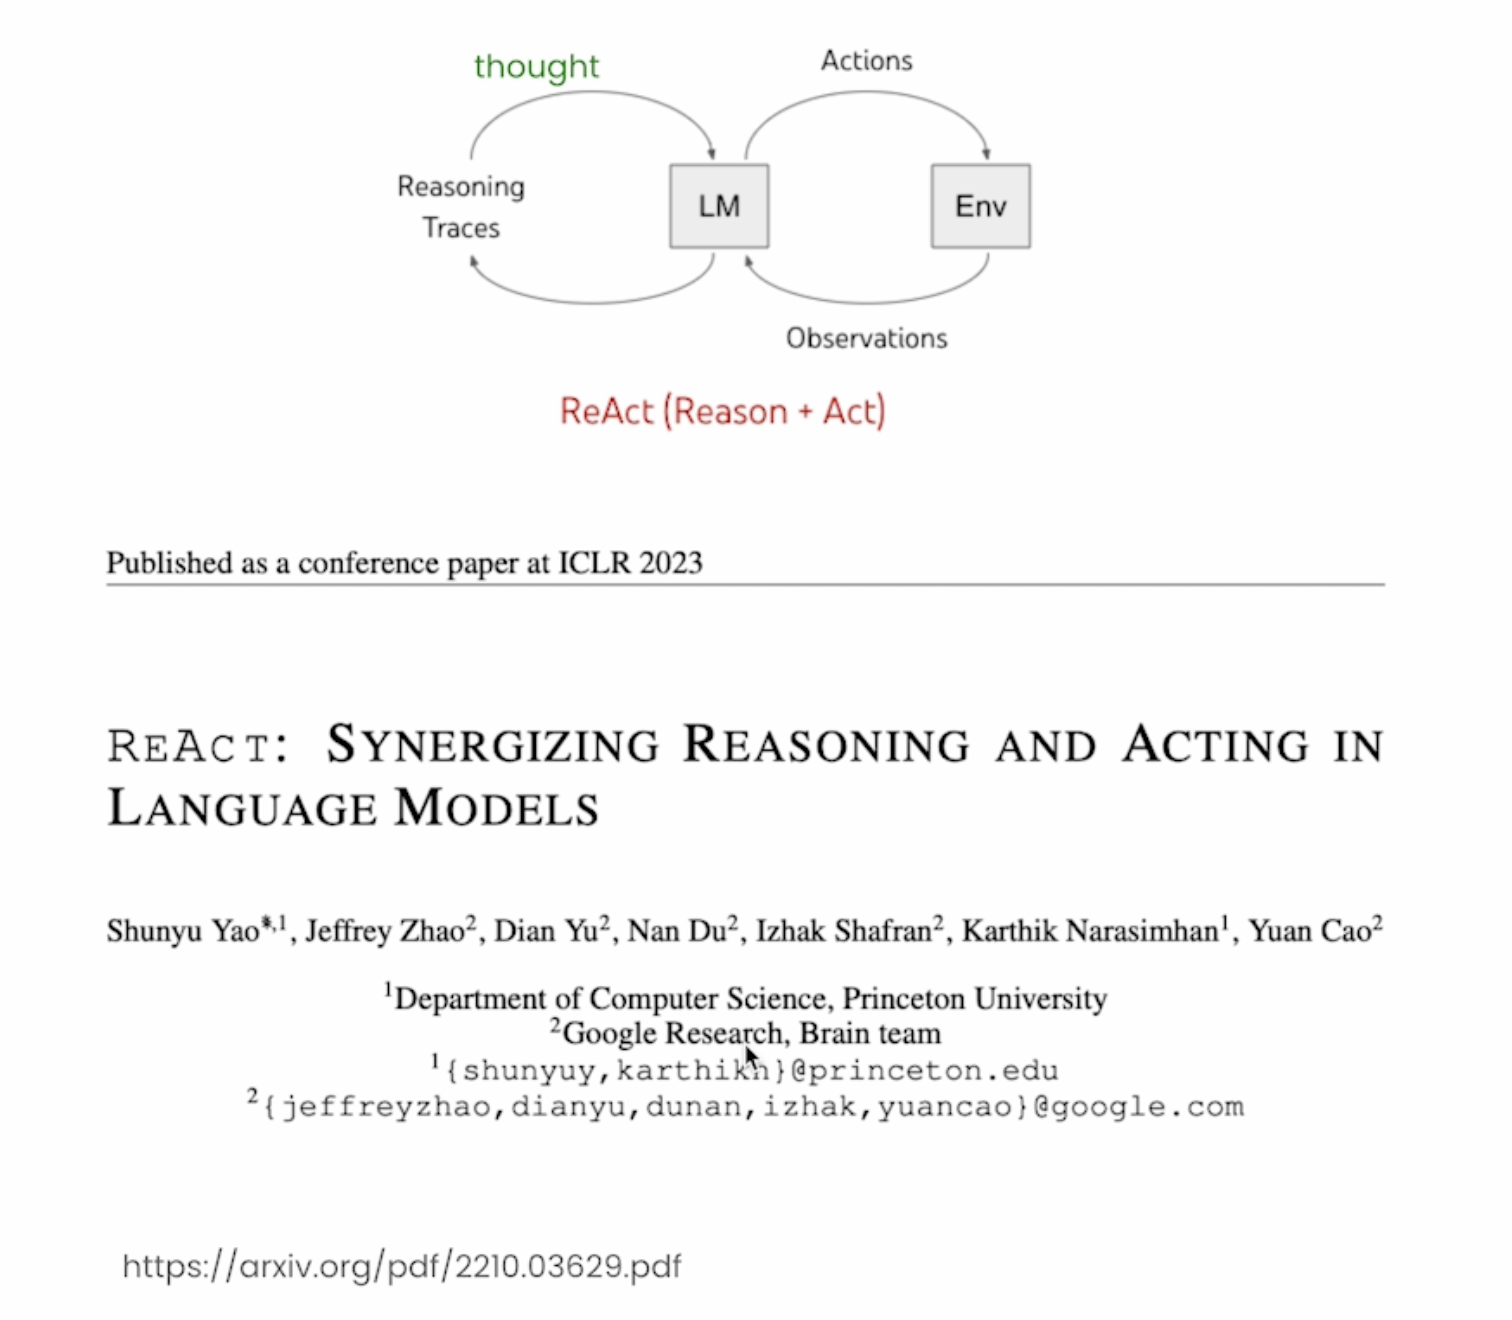

## React agent loop
### Thought:
The agent observes the current state of the environment.
### Action:
Based on its observation (and potentially internal state), the agent chooses an action to perform.
### Observation:
The environment responds to the agent's action, resulting in a new state and potentially a reward. The agent observes this new state.

This cycle repeats, and the agent learns to choose actions that maximize its cumulative reward over time.



## Using pre-build react agents:
from langgraph.prebuilt import create_react_agent

Example usage here: [How to use the prebuilt ReAct agent - langchain docs](https://https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/#code
)

In [ ]:
# based on https://til.simonwillison.net/llms/python-react-pattern
# and on https://github.com/khoirihendra/DeepLearning.AI---AI-Agents-in-LangGraph/tree/main

In [2]:
import re
import os

In [3]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}=")


_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("GOOGLE_API_KEY")

TAVILY_API_KEY=··········
GOOGLE_API_KEY=··········


In [4]:
# ### LLM setup
# PROJECT_ID = "seequent-labs-dev"  # @param {type:"string"}
# LOCATION = "us-west1"  # @param {type:"string"}

# import vertexai

# vertexai.init(project=PROJECT_ID, location=LOCATION)
# from langchain_google_vertexai import ChatVertexAI, VertexAI, VertexAIEmbeddings
# model="gemini-1.5-pro"
# llm = ChatVertexAI(model=model,temperature=0)


In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

In [6]:
llm.invoke('Whats the weather in calgary')

AIMessage(content='I do not have access to real-time information, including current weather conditions.  To get the current weather in Calgary, please check a reliable weather website or app such as Google Weather, AccuWeather, The Weather Network, or Environment Canada.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-0546158f-0398-4111-823d-668d789c17cb-0', usage_metadata={'input_tokens': 7, 'output_tokens': 50, 'total_tokens': 57, 'input_token_details': {'cache_read': 0}})

In [7]:
class Agent:
    def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system}) ## Append everything that happens in the react loop
            # Note that in Vertex AI there is no difference between a system, user and assistant messages
            # We'll keep this anyways to stay within langchain syntax and for cross-compatibility with other llm's that have these message types

    def __call__(self, message):  ## this method makes the agent callable, like a function
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self): ## execute prompt on Vertex AI LLM (gemini by default, but can also have code-bison, etc)
        response = llm.invoke(self.messages)
        return response.content


## REACT prompt
This will loop Thought-> Action->Observation

In [8]:
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_amount_drillholes_in_pattern:
e.g. average_amount_drillholes_in_pattern: Leda
returns average amount of drillholes in a minning pattern

Example session:

Question: How many drillholes are there in Leda?
Thought: I should look the drillholes amounts using average_amount_drillholes_in_pattern
Action: average_amount_drillholes_in_pattern: Leda
PAUSE

You will be called again with this:

Observation: A Leda has 20 drillholes

You then output:

Answer: A Leda has 20 drillholes
""".strip()

In [9]:
def calculate(what):
    return eval(what) #eval('20+15') will result in '35'

def average_amount_drillholes_in_pattern(name):
    """
    Proxy for a pulling info from a database or an embedding vector store
    """
    if name in "Leda":
        return("Leda pattern contains 20 drillholes")
    elif name in "Maxim":
        return("a Maxim pattern contains 30 drillholes")
    elif name in "Mina":
        return("a Mina pattern contains 15 drillholes")
    else:
        return("An average pattern contains 20 drillholes")

known_actions = {
    "calculate": calculate,
    "average_amount_drillholes_in_pattern": average_amount_drillholes_in_pattern
}

Manual Approach

In [10]:
abot = Agent(prompt)

In [11]:
question = """I have 2 patterns, a leda and mina. \
What are their combined amount of drillholes"""
abot(question)

'Thought: I need to find the number of drillholes in each pattern individually, then add them together.  I can use the `average_amount_drillholes_in_pattern` action for each pattern.\n\nAction: average_amount_drillholes_in_pattern: Leda\nPAUSE\n'

In [12]:
## Can inspect the messages via this attribute:
# abot.messages

In [13]:
next_prompt = "Observation: {}".format(average_amount_drillholes_in_pattern("Leda"))
print(next_prompt)

Observation: Leda pattern contains 20 drillholes


In [14]:
next_prompt = "Observation: {}".format(average_amount_drillholes_in_pattern("Mina"))
print(next_prompt)

Observation: a Mina pattern contains 15 drillholes


In [15]:
abot(next_prompt)

'Thought: I have the number of drillholes for Mina. I need to get the number for Leda and then sum them.\n\nAction: average_amount_drillholes_in_pattern: Leda\nPAUSE\n'

In [16]:
# abot.messages

In [17]:
next_prompt = "Observation: {}".format(eval("20 + 15"))
print(next_prompt)

Observation: 35


In [18]:
abot(next_prompt)

'Thought: I have the number of drillholes for both Leda (35) and Mina (15).  I can now calculate the total.\n\nAction: calculate: 35 + 15\nPAUSE\n'

Add loop to run the agent automatically

In [19]:
action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to select an action name and required inputs as a tuple: ('action's name', 'action inputs')

# ^: Matches the beginning of the string. This ensures that the string must start with "Action: ".
# Action:: Matches the literal string "Action: ".
# (\w+): This is the first capturing group. \w matches any word character (letters, numbers, and underscore). + means one or more word characters. So, this part captures the action name.
# :: Matches a colon followed by a space.
# (.*): This is the second capturing group. . matches any character (except newline). * means zero or more occurrences of any character. This part captures the action argument.
# $: Matches the end of the string. This ensures that the entire string must match the pattern, not just a part of it.



In [20]:
def query(question, max_turns=5):  #maximum of 5 REACT loops per call
    i = 0
    bot = Agent(prompt) ## Agent initialization with default system prompt, giving it a REACT template
    next_prompt = question
    while i < max_turns:  ## Run untill we have completed 5 loops
        i += 1. ## increment the counter
        result = bot(next_prompt) ## This retrieves the llm result -a  thought+action
        print(result) ## printout to inspect the llm result
        actions = [        ## This applies the regex on the llm result to extract a list of actions via list comprehension
            action_re.match(a)
            for a in result.split('\n')
            if action_re.match(a)
        ]
        if actions:  ## if we could extract actions, we should execute them
            # There is an action to run
            action, action_input = actions[0].groups() ## take the zeroth ('action's name', 'action inputs') tuple
            if action not in known_actions:  ## check if this action is defined
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input)) ## let the user know an action will be run
            observation = known_actions[action](action_input) ## look up action's name in known_actions dict and pass the inputs to it.
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)  ## pass the observation back to the agent
        else:
            return ## if there are no actions, the model has arrived at the result

In [21]:
question = """I have 2 patterns, a leda and mina. \
What are their combined amount of drillholes"""
query(question)

Thought: I need to find the number of drillholes in each pattern individually, then add them together.  I can use the `average_amount_drillholes_in_pattern` action for each pattern.

Action: average_amount_drillholes_in_pattern: Leda
PAUSE

 -- running average_amount_drillholes_in_pattern Leda
Observation: Leda pattern contains 20 drillholes
Thought: I have the number of drillholes for Leda. Now I need to get the number for Mina.

Action: average_amount_drillholes_in_pattern: Mina
PAUSE

 -- running average_amount_drillholes_in_pattern Mina
Observation: a Mina pattern contains 15 drillholes
Thought: I have the drillhole counts for both Leda and Mina.  Now I just need to add them together.

Action: calculate: 20 + 15
PAUSE

 -- running calculate 20 + 15
Observation: 35
Answer: The combined amount of drillholes in a Leda and a Mina pattern is 35.

